This notebook illustrates inference with _Swyft_ for **$\Lambda$CDM** cosmology with a simulator of **Stage IV 3x2pt photometric probes**

That is, our observables are the weak-lensing, galaxy clustering and the cross-correlated angular power spectra at different tomographic redshift bins

We focus here on the **12 nuisance parameters**. The main steps are:

- Load the pre-computed mock observation and the data store (see notebook 'Swyft_3x2pt_LCDM_cosmo_coverage')

- Rotate the data vector to Cholesky basis, and load the PCA matrix

- Define compression network

- Train the network (compression+inference)

- Plot marginal posteriors and compare with results from MCMC chains

In [1]:
# General imports
import swyft #the version used is 0.4.6.
import torch
import pytorch_lightning as pl

import numpy   as np
from time      import time
from scipy     import stats
from getdist import plots, loadMCSamples  #to plot MCMC results

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'serif': ['cmr10']})

# Having a GPU makes training much faster, but it's not compulsory
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

True

Set fiducial values for ($H_0$, 100$\omega_b$, $\omega_c$, $n_s$, $\mathrm{ln}(10^{10}A_s)$, $A_{\rm IA}$, $\eta_{\rm IA}$, $b_1$, $b_2$, $b_3$, $b_4$, $b_5$, $b_6$, $b_7$, $b_8$, $b_9$, $b_{10}$)

In [3]:
fiducial = np.array([67.,2.2445,0.1206,0.96,3.0568,1.72,-0.41,1.09977,1.22025,1.2724,1.31662,1.35812,1.39982,1.44465,1.4965,1.56525,1.74299])

Load pre-computed inverse of Fisher matrix (see 'Fisher' folder)

In [4]:
N_pars = 17 # total number of parameters (cosmo+nuisance)
Finv = np.load('./Fisher/Finv_LCDM.npy')

# obtain 1sigma values from Fisher
sigmas=[]
for i in range(N_pars): 
    sigmas.append(np.sqrt(Finv[i,i]))

Estimate the bounds of the prior region based on the Fisher results

In [6]:
bounds = []
for i in range(N_pars):
    bounds.append([fiducial[i]-5*sigmas[i],fiducial[i]+5*sigmas[i]])
bounds = np.array(bounds)

Load the Cholesky matrix (we will need it later)

In [9]:
Lfid = np.load('./Aux_files/cholesky_LCDM.npy',allow_pickle=True).item()

Load mock observation (we will need it later)

In [10]:
obs = np.load('./Aux_files/obs_LCDM.npy',allow_pickle=True).item()

### Load ZarrStore with simulations

In [13]:
store = swyft.ZarrStore("./Store_LCDM_5e4sims")       
store = store.get_sample_store()

Rotate data to the Cholesky basis (in order to decouple the different spectra)

In [14]:
ell_lims    = np.logspace(np.log10(lmin),np.log10(lmax),Nbin_ell)
ells   = 0.5*(ell_lims[:-1]+ell_lims[1:])

Cells_chol = np.zeros((N_sims,N_spectra,Nbin_ell-1))
noise_chol = np.zeros((N_sims,N_spectra,Nbin_ell-1))

for ind,ell in enumerate(ells):
    Linv = np.linalg.inv(Lfid[str(int(ell))]) #inverse of Cholesky matrix
    Cells_chol[...,ind] = np.matmul(Linv, store['C_ells'][...,ind].T).T
    noise_chol[...,ind] = np.matmul(Linv, store['noise'][...,ind].T).T

store_samples = swyft.Samples(z=store['z'], C_ells=Cells_chol,noise=noise_chol) #redefine store with rotated data 

### Load  the PCA matrix Vh

In [15]:
Vh_proj = np.load('./Aux_files/SVD_LCDM.npy',allow_pickle=True)
Vh_proj = torch.from_numpy(Vh_proj).cuda().double()
lenV = len(Vh_proj) #number of PCA components

### Define the network architecture

In [16]:
class Network(swyft.AdamWReduceLROnPlateau,swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.learning_rate = 1e-3
        self.batch_size = 256 
        self.num_params_show = 12 # number of parameters of interest, obviously cannot be larger than N_pars
        self.num_feat_param = 2 # number of features per parameter of interest (2 seem to work well)
        self.marginals  = self.get_marginals(self.num_params_show) 
        self.flatten = torch.nn.Flatten()
        self.norm =  swyft.networks.OnlineStandardizingLayer(torch.Size([lenV]), epsilon=1e-50)
        
        #compression network, here one could play with number of layers and neurons
        self.sequential = torch.nn.Sequential(
            torch.nn.LazyLinear(256), 
            torch.nn.ReLU(),
            torch.nn.LazyLinear(self.num_params_show*self.num_feat_param),
            torch.nn.LazyBatchNorm1d()
        )
        
        #pre-defined MLP to get 1-dim marginals
        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = self.num_feat_param, 
                                                       num_params = self.num_params_show, varnames = 'z', 
                                                       num_blocks = 4, dropout = 0.1)
        
        #pre-defined MLP to get 2-dim marginals
        self.logratios2 = swyft.LogRatioEstimator_Ndim(num_features = 2*self.num_feat_param,
                                                       marginals = self.marginals, varnames = 'z',
                                                       num_blocks = 4, dropout = 0.1)

    @staticmethod
    def get_marginals(n_params): #get all possible marginal combinations given number of parameters
        marginals = []
        for i in range(n_params):
            for j in range(n_params):
                if j>i: marginals.append((i, j))
        return tuple(marginals)
    
    def forward(self, A, B):

        C_ells_noisy_chol = A['C_ells']+A['noise']  #add noise to the spectra
        fC_ells_noisy_chol = self.flatten(C_ells_noisy_chol) #flatten all spectra into a large vector
        
        s = (Vh_proj@fC_ells_noisy_chol.T).T #project to PCA basis
        s = self.norm(s)   #normalization
        s = self.sequential(s) #linear compression
        
        z  = B['z'][...,-self.num_params_show:] #select only params of interest
        
        # Use num_feat_param per 1-dim marginal, s1 has shape (batch, num_params_show, num_feat_param)
        s1 = s.reshape(-1, self.num_params_show, self.num_feat_param)  
        # Use num_feat_param+num_feat_param per 2-dim marginal, s2 has shape (batch, num_marginals, 2*num_feat_param)
        s2 = torch.stack([torch.cat([s1[:, i, :], s1[:, j, :]], dim = -1) for i, j in self.marginals], dim = 1)  
        logratios1 = self.logratios1(s1, z)
        logratios2 = self.logratios2(s2, z)
        return logratios1, logratios2

This function allows to resample the noise on the fly, it helps a lot with the training

In [17]:
def resampler(x): # we mix the noise of different spectra across different realizations
                  # (notice that we can do this because we rotated to Cholesky basis, where spectra are independent)
    i = np.random.randint(N_sims, size = (N_spectra,)) 
    noise = np.array([store_samples['noise'][j][k] for k, j in enumerate(i)]) 
    x['noise'] = noise
    return x

### Train the network

In [18]:
%%time
# Perform inference
network = Network()
dm = swyft.SwyftDataModule(store_samples, num_workers = 3, 
                            batch_size = network.batch_size,
                            val_fraction = 0.2, #we use 20% of the samples for validation
                            on_after_load_sample=resampler) #do noise resampling

trainer = swyft.SwyftTrainer(accelerator = DEVICE, devices=1, 
                             max_epochs = -1, precision = 64)


trainer.fit(network, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


To get consistent results, we also need to rotate the mock observation to the Cholesky basis

In [ ]:
oCells_chol = np.zeros((N_spectra,Nbin_ell-1))
onoise_chol = np.zeros((N_spectra,Nbin_ell-1))

for ind,ell in enumerate(ells):
    Linv = np.linalg.inv(Lfid[str(int(ell))])
    oCells_chol[...,ind] = np.matmul(Linv, obs['C_ells'][...,ind].T).T
    onoise_chol[...,ind] = np.matmul(Linv, obs['noise'][...,ind].T).T
    
obs_p = swyft.Sample(dict(C_ells=oCells_chol, noise=0.*onoise_chol)) # we choose to work with a noiseless observation

We quickly evaluate the trained network with the mock observation and many parameter samples ($5\times 10^5$) drawn from the prior

In [21]:
lower = []
width = []
for i in range(N_pars-network.num_params_show,N_pars):
    lower.append([fiducial[i]-5*sigmas[i]])
    width.append([10*sigmas[i]])

prior_samples = swyft.Samples(z = stats.uniform(np.array(lower), 
                                                np.array(width)).rvs(size=(500_000,network.num_params_show)))

predictions = trainer.infer(network, obs_p, prior_samples)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

We post-process the MCMC chains using getdist

In [22]:
chains = {'varnuis_bbin': {'path': './MontePython/chains/3x2pt_LCDM/2024-01-17_1000000_','burn_in': 0.3,'Nchains': 18}}

def analyze_chain(name,chain):
    sample = loadMCSamples(chain['path'], settings={'ignore_rows': chain['burn_in']})
    chain['sample'] = sample
    return chain

#list of parameters that we want to plot
plot_pars = ['A_IA','eta_IA','b_1','b_2','b_3','b_4','b_5','b_6','b_7','b_8','b_9','b_10']

chains = {name: analyze_chain(name,chain) for name,chain in chains.items()}
LCDM_3x2pt = [chain['sample'] for chain in chains.values()]

#create instance of single_plotter just to be able to plot posteriors from the MCMC later
g = plots.get_single_plotter(width_inch=8) 
g.settings.axes_labelsize=16

<Figure size 800x600 with 0 Axes>

### Plot marginal posteriors and compare Swyft results with MCMC

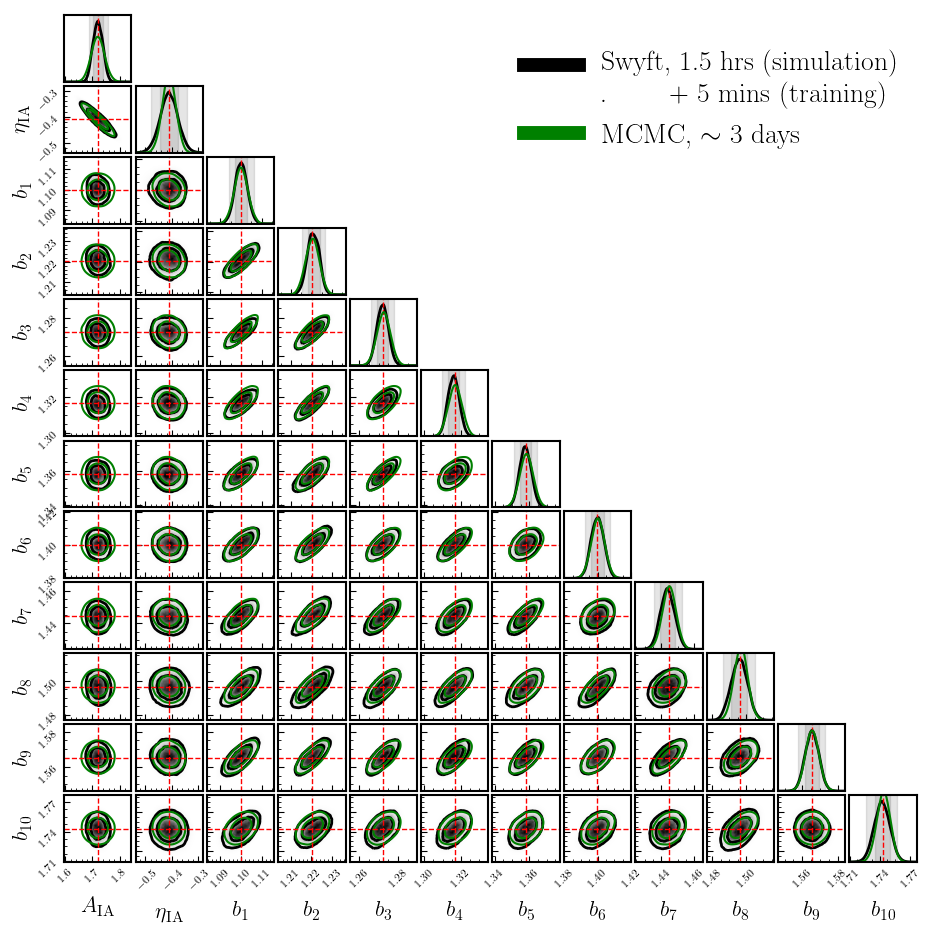

In [27]:
%matplotlib inline

show_MCMC = True #Flag to decide whether we want to show the MCMC posteriors
N_plot = network.num_params_show
fig, axes = plt.subplots(N_plot, N_plot, figsize=(11,11))

color_swyft='black'
color_mcmc='green'
color_fid = 'red'
fontsize_tick = 8

# corner plot with swyft predictions
swyft.plot_corner(predictions, 
                  ('z[0]', 'z[1]', 'z[2]','z[3]', 'z[4]', 'z[5]','z[6]', 'z[7]', 'z[8]','z[9]', 'z[10]', 'z[11]'),
                  fig=fig, bins = 100, smooth = 1,contours_1d=False)

for i in range(N_plot): # add fiducial values and 1D posteriors from MCMC
    #fiducial 
    axes[i, i].axvline(fiducial[5+i], color=color_fid,lw=1.,linestyle='dashed')
    axes[i, i].minorticks_on()
    axes[i, i].tick_params(axis='both', which='major',direction="in", labelsize=fontsize_tick,rotation=45,size=4)
    axes[i, i].tick_params(axis='both', which='minor',direction="in", labelsize=fontsize_tick,rotation=45,size=2,left=False)
    #MCMC
    if show_MCMC:
        g.plot_1d(LCDM_3x2pt, plot_pars[i], ax = axes[i,i],colors=[color_mcmc],lws=[1.5],
                  alphas=[1.0],normalized='True',no_ylabel='True',lims=[bounds[5+i,0],bounds[5+i,1]])

for i,j in network.marginals: # add fiducial values and 2D posteriors from MCMC
    # fiducial
    axes[j, i].axvline(fiducial[5+i], color=color_fid,lw=1.,linestyle='dashed')
    axes[j, i].axhline(fiducial[5+j], color=color_fid,lw=1.,linestyle='dashed')
    axes[j, i].minorticks_on()
    axes[j, i].tick_params(axis='both', which='major',direction="in", labelsize=fontsize_tick,rotation=45,size=4)
    axes[j, i].tick_params(axis='both', which='minor',direction="in", labelsize=fontsize_tick,rotation=45,size=2)
    #MCMC
    if show_MCMC:
        g.plot_2d(LCDM_3x2pt, plot_pars[i], plot_pars[j],ax = axes[j,i], colors=[color_mcmc],lws=[1.5],
                  alphas=[1.0],lims = [bounds[5+i,0],bounds[5+i,1], bounds[5+j,0],bounds[5+j,1]])

#play with tick settings                
for i in range(N_plot):
    axes[N_plot-1, i].tick_params(axis='both', which='major',direction="in", labelsize=fontsize_tick,rotation=45,size=4)
    axes[N_plot-1, i].tick_params(axis='both', which='minor',direction="in", labelsize=fontsize_tick,rotation=45,size=2)
    axes[N_plot-1, i].minorticks_on() 

for i in range(1,N_plot):
    axes[i, 0].tick_params(axis='both', which='major',direction="in", labelsize=fontsize_tick,rotation=45,size=4)
    axes[i, 0].tick_params(axis='both', which='minor',direction="in", labelsize=fontsize_tick,rotation=45,size=2)
    axes[i, 0].minorticks_on() 

#change appearance of axes    
for i,j in network.marginals:
    [x.set_linewidth(1.5) for x in axes[j, i].spines.values()]
for i in range(N_plot):
    [x.set_linewidth(1.5) for x in axes[i, i].spines.values()]

    
# add legend
labels = ['\n Swyft, 1.5 hrs (simulation) \n + 5 mins (training)']
colors = [color_swyft]
alphas = [1.0]
if show_MCMC:
    labels.append(r'MCMC, $\sim$ 3 days')
    colors.append(color_mcmc)
    alphas.append(1.)
lines = [Line2D([0], [0], color=colors[i],alpha=alphas[i], linewidth=10, linestyle='-') for i in range(2)]
plt.legend(lines, labels,loc=(-5.0,10.5),fontsize=20,frameon=False)

# This is only required because we are comparing with results from MCMC using getdist... 
# when using g.plot_1d and g.plot_2d, this adds unwanted ticks and labels in the middle subplots of the corner plot
# so we have to manually remove ticks and labels
if show_MCMC:
    for i in range(1,N_plot-1):
        axes[N_plot-1, i].set_ylabel(None)
        axes[N_plot-1, i].set_yticklabels([])
        
        for j in range(i,N_plot-1):
            axes[j, i].set_xlabel(None)
            axes[j, i].set_ylabel(None)
            axes[j, i].set_xticklabels([])
            axes[j, i].set_yticklabels([]) 
            
    for i in range(N_plot-1):
        axes[i,0].set_xlabel(None)
        axes[i,0].set_xticklabels([])

# save figure
plt.savefig('Swyft_vs_MCMC_nuisance_LCDM.pdf',bbox_inches='tight')